In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples
import util

ImportError: cannot import name 'build_odeint' from 'jax.experimental.ode' (/Users/sheldon/projects/covid/lib/jax/jax/experimental/ode.py)

# Run Inference

In [243]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

model = 'SEIR'
prob_model = SEIR_stochastic

save = True

#places = state_data.keys()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
places = ['NY']
#places = ['US']
#places = ['ID']

for place in places:

    print(f"******* {place} *********")
    
    start = pd.Timestamp('2020-03-04')
    confirmed = data[place]['data'].confirmed[start:]
    start = confirmed.index.min()

    T = len(confirmed)
    N = data[place]['pop']

    args = {
        'N': N,
        'T': T,
        'drift_scale': 2e-1,
        'det_conc': 10,
    }

#     args = {
#         'N': N,
#         'T': T,
#         'drift_scale': 2e-1,
#         'det_conc': 100,
#         'sigma_shape': 5,
#         'gamma_shape': 1,
#         'beta_shape': 1
#     }

    kernel = NUTS(prob_model,
                  init_strategy = numpyro.infer.util.init_to_median())

    mcmc = MCMC(kernel, 
                num_warmup=1000, 
                num_samples=1000, 
                num_chains=1)

    print("Running MCMC")
    mcmc.run(jax.random.PRNGKey(2), 
             obs = confirmed.values,
             **args)

    mcmc.print_summary()
    mcmc_samples = mcmc.get_samples()
    
    # Prior samples for comparison
    prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
    prior_samples = prior(PRNGKey(2), **args)

    # Posterior predictive samples for visualization
    args['drift_scale'] = 0 # set drift to zero for forecasting
    post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
    post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

    if save:
        save_samples(place,
                     prior_samples,
                     mcmc_samples, 
                     post_pred_samples)

******* NY *********
Running MCMC


sample: 100%|██████████| 2000/2000 [05:04<00:00,  6.57it/s, 1023 steps of size 9.59e-30. acc. prob=1.00] 
/Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/numpyro/diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  rho_k = 1. - (var_within - gamma_k_c.mean(axis=0)) / var_estimator



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0  37197.50      0.00  37197.50  37197.50  37197.50       nan       nan
        I0   7787.79      0.00   7787.79   7787.79   7787.79      0.50      1.00
   beta[0]      1.86      0.00      1.86      1.86      1.86      0.50      1.00
   beta[1]      2.26      0.00      2.26      2.26      2.26      0.50      1.00
   beta[2]      2.57      0.00      2.57      2.57      2.57      0.50      1.00
   beta[3]      2.77      0.00      2.77      2.77      2.77      0.50      1.00
   beta[4]      3.30      0.00      3.30      3.30      3.30      0.50      1.00
   beta[5]      3.20      0.00      3.20      3.20      3.20      0.50      1.00
   beta[6]      3.61      0.00      3.61      3.61      3.61      0.50      1.00
   beta[7]      3.75      0.00      3.75      3.75      3.75      0.50      1.00
   beta[8]      4.41      0.00      4.41      4.41      4.41      0.50      1.00
   beta[9]      4.17      0

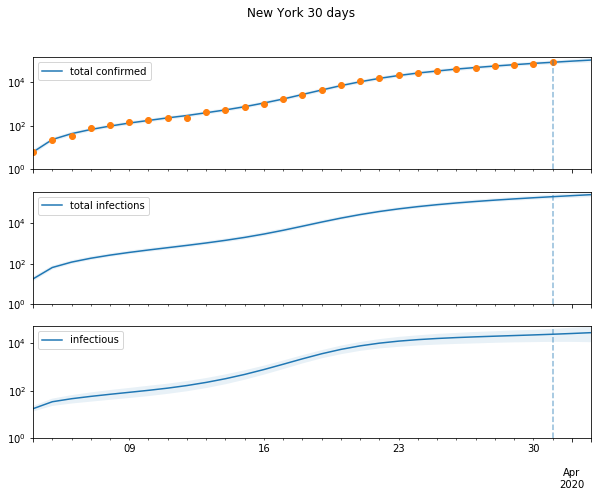

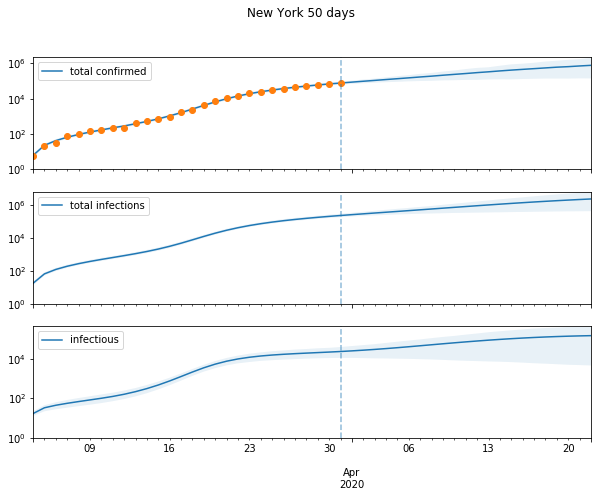

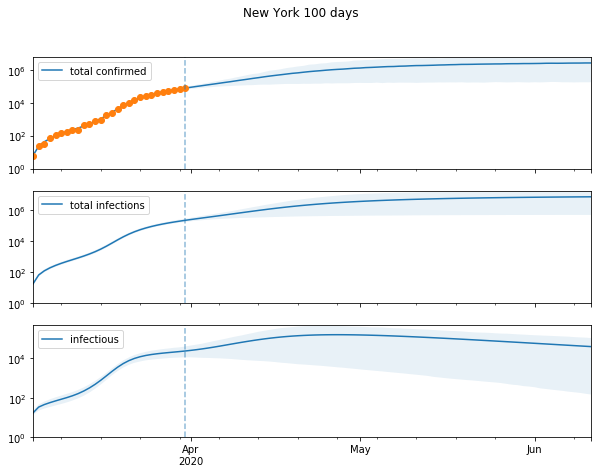

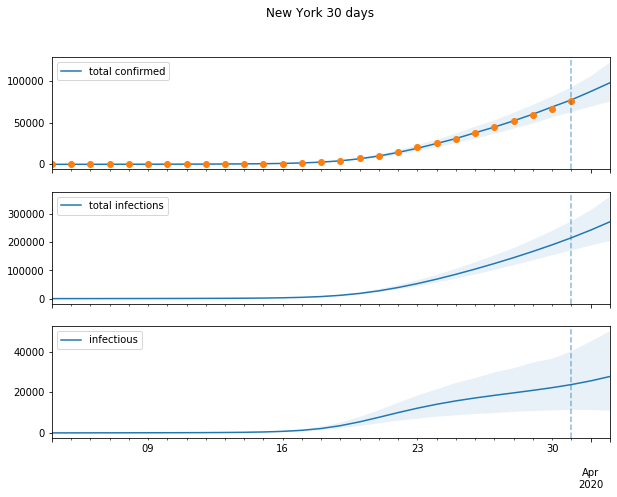

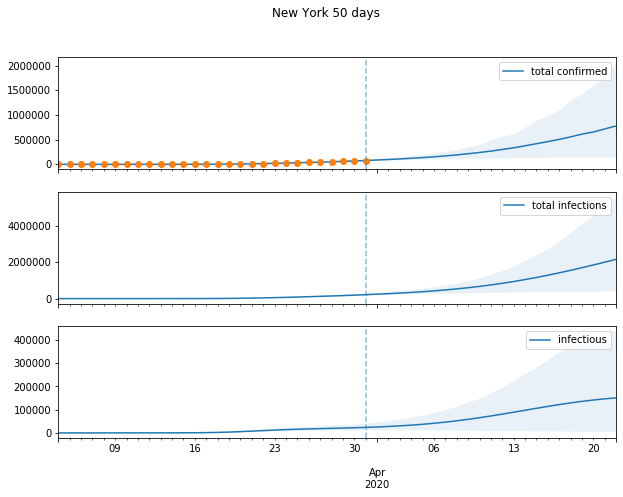

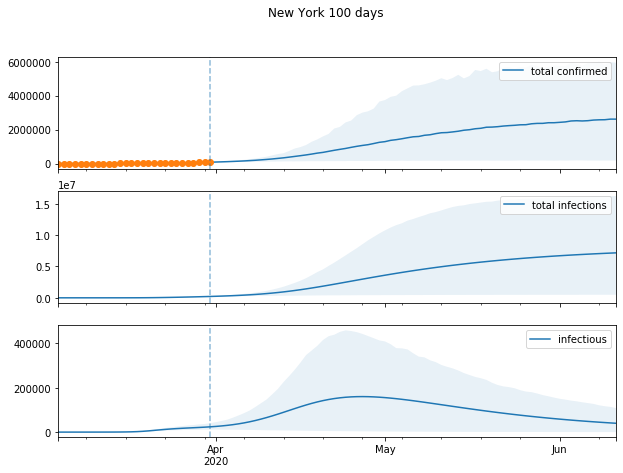

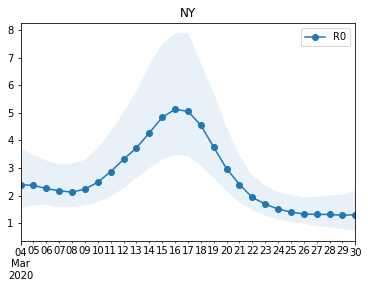

In [242]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

start = '2020-03-04'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['ID']
places = ['NY']
#places = state_data.keys()

save = True

for place in places:
    
    confirmed = data[place]['data'].confirmed[start:]
    start_ = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    try:
        prior_samples, mcmc_samples, post_pred_samples = load_samples(place)
    except:
        continue
    
    # Inspect and Save Results    
    for scale in ['log', 'lin']:
        for T in [30, 50, 100]:

            t = pd.date_range(start=start_, periods=T, freq='D')
            
            fig, ax = plt.subplots(nrows=3, figsize=(10,7), sharex=True)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[0], plot_fields=['y'], model=model)
            confirmed.plot(ax=ax[0], style='o')

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[1], plot_fields=['C'], model=model)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[2], plot_fields=['I'], model=model)

            [a.axvline(confirmed.index.max(), linestyle='--', alpha=0.5) for a in ax]

            plt.suptitle(f'{place_names[place]} {T} days ')
            
            if scale == 'log':
                [a.set_ylim(bottom=1) for a in ax]
                [a.set_yscale('log') for a in ax]
                
            if save:
                filename = f'vis/{place}_predictive_scale_{scale}_T_{T}.png'
                plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start_, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': np.median(R0, axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    if save:
        filename = f'vis/{place}_R0.png'
        plt.savefig(filename)

    plt.title(place)
    plt.show()

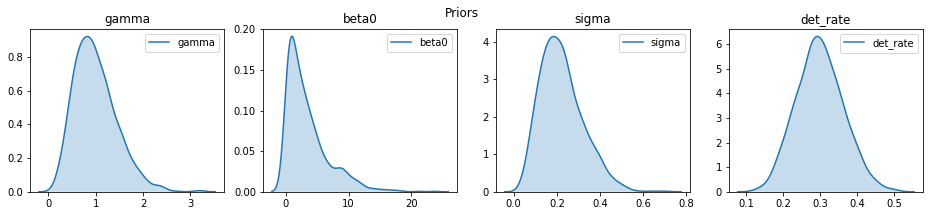

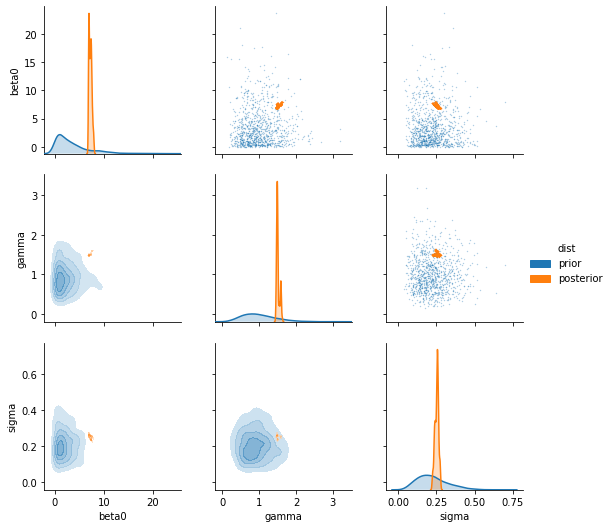

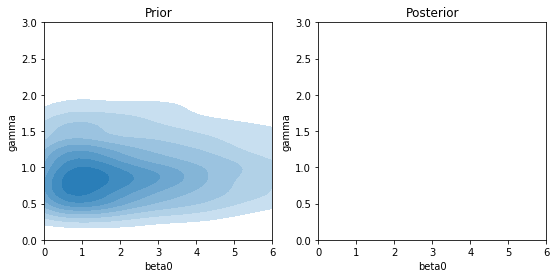

In [220]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    

# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=0.1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

# Compare gamma and beta0 specifically
fig, ax = plt.subplots(figsize=(9,4), ncols=2)

xlim = [0, 6]
ylim = [0, 3]

for df, name, a in zip([prior_df, posterior_df], ['Prior', 'Posterior'], ax):
    sns.kdeplot(df['beta0'], 
                df['gamma'], 
                ax=a,
                shade=True, 
                shade_lowest=False)
    a.set_title(name)
    a.set_xlim(xlim)
    a.set_ylim(ylim)

plt.show()

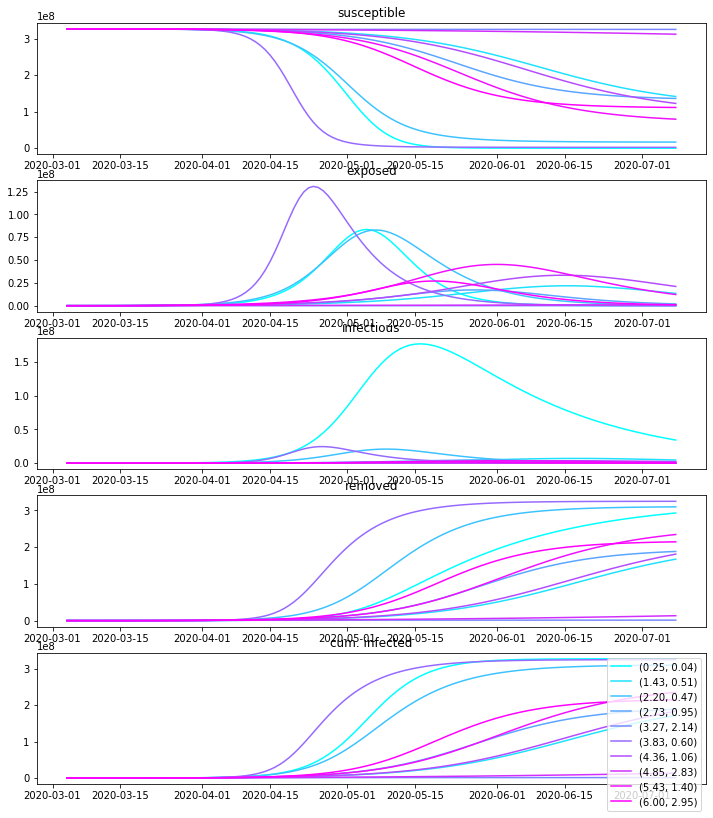

In [181]:
samples = post_pred_samples
X = np.concatenate((samples['x'], samples['x_future']), axis=1)

T = X.shape[1]
t = pd.date_range(start, freq='D', periods=T)
levels = 10

beta0 = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
inds = np.argsort(beta0)
level_inds = inds[np.linspace(0, len(I)-1, levels).astype('int32')]

fig, ax = plt.subplots(figsize=(12,14), nrows=5)


beta0_gamma = [f'({beta0[i]:.2f}, {gamma[i]:.2f})' for i in level_inds]

for col, name, a in zip([0, 1, 2, 3, 4], 
                       ['susceptible', 'exposed', 'infectious', 'removed', 'cum. infected'],
                       ax):

    X_levels = np.squeeze(X[level_inds,:,col].T)

    lines = []
    cmap = plt.cm.cool
    for i in range(levels):
        lines += a.plot(t, X_levels[:,i], color=cmap(i*30))

    a.set_title(name)
    
plt.legend(beta0_gamma)

plt.show()

In [131]:
n = 50
for i in range(n):
    print(plt.cm.jet(i * n / 256))

(0.0, 0.0, 0.5, 1.0)
(0.0, 0.28431372549019607, 1.0, 1.0)
(0.13598987982289687, 1.0, 0.8317520556609741, 1.0)
(0.7685009487666034, 1.0, 0.19924098671726753, 1.0)
(1.0, 0.46550472040668145, 0.0, 1.0)
(0.589126559714795, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0,

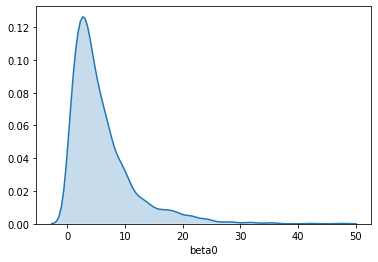

In [61]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

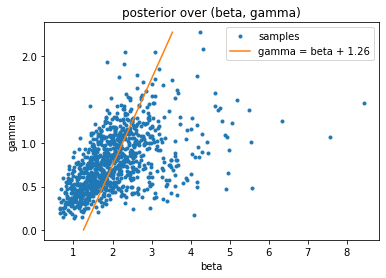

R0: 2.9294224


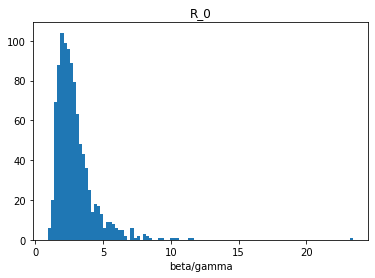

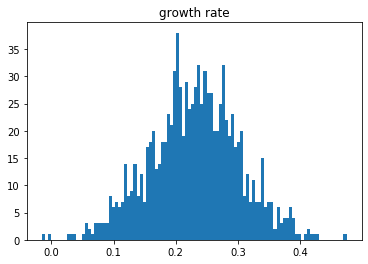

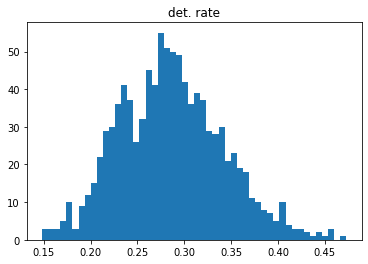

In [44]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

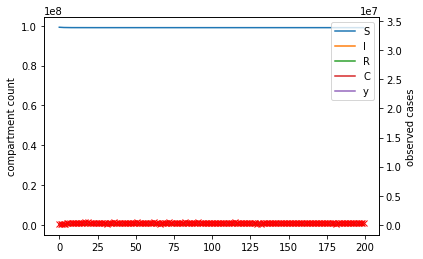

> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/random.py(278)_random_bits()
-> raise TypeError("requesting more random bits than a single call provides.")
(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/random.py(339)_uniform()
-> bits = _random_bits(key, nbits, shape)
(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/linear_util.py(149)call_wrapped()
-> ans = self.f(*args, **dict(self.params, **kwargs))
(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/interpreters/partial_eval.py(358)trace_to_jaxpr()
-> jaxpr, (out_pvals, consts, env) = fun.call_wrapped(pvals)
(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/interpreters/xla.py(474)_xla_callable()
-> fun, pvals, instantiate=False, stage_out_calls=True, bottom=True)
(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/jax/linear_util.py(220)memoized_fun()
-> ans = call(fun, *args)
(Pdb) up
> /Users/sheldon/opt/anac

(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/numpyro/distributions/util.py(30)binomial()
-> return _binomial(key, p, n, n_max, shape)
(Pdb) up
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/numpyro/distributions/discrete.py(146)sample()
-> return binomial(key, self.probs, n=self.total_count, shape=sample_shape + self.batch_shape)
(Pdb) p shape
*** NameError: name 'shape' is not defined
(Pdb) down
> /Users/sheldon/opt/anaconda3/lib/python3.7/site-packages/numpyro/distributions/util.py(30)binomial()
-> return _binomial(key, p, n, n_max, shape)
(Pdb) p shape
(99,)
(Pdb) p n
DeviceArray([  378542.94,   591991.1 ,   891882.8 ,  1310996.6 ,
              1897214.5 ,  2739957.5 ,  3978993.2 ,  5715533.5 ,
              8014328.5 , 10968259.  , 14857576.  , 19871924.  ,
             26070054.  , 33433828.  , 41638510.  , 49933976.  ,
             57607772.  , 64366550.  , 70153480.  , 75006330.  ,
             79028400.  , 82334070.  , 85028060.  , 87217740. 

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
    return samples
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=100, T_future=100, N=1e8)
        
    samples = test_prior_predictive()

In [215]:
T = 20
shape = 1
mean = 10

for x in range(10):
    d = dist.Gamma(x, 1)
    print(d.mean)


# with numpyro.handlers.seed(rng_seed=1):
#     X = numpyro.sample("imm", dist.Gamma(shape, shape/mean), sample_shape=(T-1,))
# x = np.linspace(0, 120, 100)
# plt.plot(x, np.exp(d.log_prob(x)))

print(X)


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
[ 3.2941546  31.561396    0.73156303  0.663138    8.842076   25.504183
  2.0311763   4.144132    0.5086255  44.68679    10.394677    1.6967298
  0.09416187  7.9079804   1.8338768   6.55056    15.757981   13.64725
 26.5712    ]
